<a href="https://colab.research.google.com/github/valid999/Generative_Adversarial_Network/blob/main/Training_Generative_Adverserial_Networks(GANs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adverserial Network
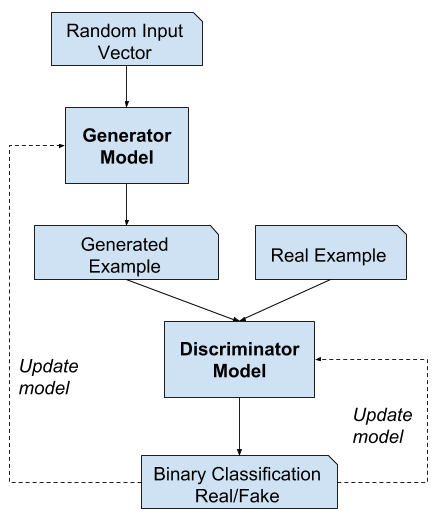


In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor , Normalize , Compose
from torchvision.datasets import MNIST



mnist = MNIST(root = 'data',
              train = True ,
              download = True ,
              transform = Compose([ToTensor() , Normalize(mean = (0.5 ,) , std = (0.5))]) # Data in the range -1 , 1
              )

100%|██████████| 9912422/9912422 [00:00<00:00, 111524326.36it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108934976.46it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64111421.73it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1124986.94it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
img , label = mnist[0]
print("label: " , label)
print(img[: , 10:15 , 10:15])
torch.min(img) ,  torch.max(img)

label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0 , 1)

Label:  5


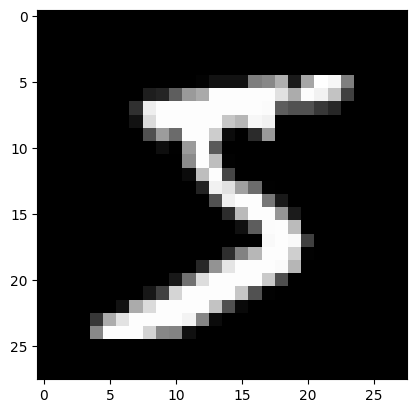

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


img_norm = denorm(img)
plt.imshow(img_norm[0] , cmap = 'gray')
print("Label: " , label)


In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist , batch_size , shuffle = True)

first batch
torch.Size([100, 1, 28, 28])
tensor([3, 4, 3, 2, 2, 0, 7, 0, 9, 6, 6, 3, 2, 3, 1, 4, 8, 3, 6, 2, 7, 5, 4, 1,
        8, 2, 3, 7, 3, 3, 1, 7, 0, 5, 6, 0, 9, 6, 6, 9, 1, 4, 3, 7, 8, 3, 4, 7,
        0, 5, 0, 6, 3, 7, 8, 6, 1, 4, 0, 0, 2, 6, 2, 3, 1, 5, 5, 5, 1, 0, 9, 9,
        5, 6, 2, 0, 6, 4, 3, 6, 9, 5, 9, 1, 4, 8, 9, 7, 3, 7, 2, 6, 2, 5, 1, 1,
        1, 3, 3, 8])


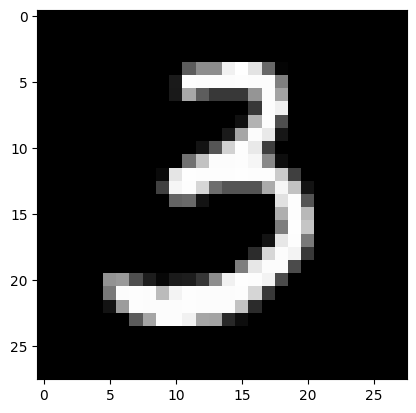

In [6]:
for img_batch , label_batch in data_loader:
  print('first batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0] , cmap = 'gray')
  print(label_batch)
  break


In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

#### Discriminator Network

In [9]:
# Discriminator Network

image_size = 784
hidden_size = 256

In [10]:
# Use the CNN , we will do a semple feedforward neural network
import torch.nn as nn

D = nn.Sequential(

    nn.Linear(image_size , hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size , hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size , 1),
    nn.Sigmoid()
)

In [11]:
D.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [12]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

#### Generator Network

In [36]:
latent_size = 64  # The input for the generato4r used as the seed

G = nn.Sequential(
    nn.Linear(latent_size , hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size , hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size , image_size),
    nn.Tanh()
)

In [14]:
y = G(torch.randn(3 , latent_size)) # 3 mean we put three vector in to the Generator
gen_imgs = denorm(y.reshape((-1 , 28 , 28)).detach())

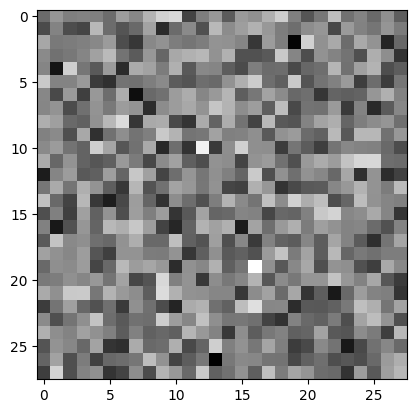

In [15]:
plt.imshow(gen_imgs[2] , cmap = 'gray')

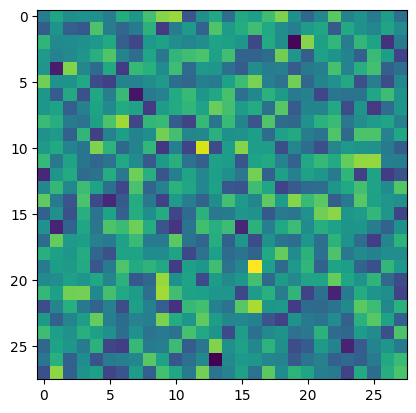

In [16]:
plt.imshow(gen_imgs[2])

In [17]:
G.to(device);

In [18]:
criterion = nn.BCELoss() # Binary cross entropy function
d_optimizer = torch.optim.Adam(D.parameters() , lr = 0.0002)

### Train the Discriminator

In [19]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [20]:
def train_discriminator(images):

  # Create the labels which are later used as input for the BCE loss
  real_labels = torch.ones(batch_size , 1).to(device)
  fake_labels = torch.zeros(batch_size , 1).to(device)

  # Loss for real images
  outputs = D(images)
  d_loss_real = criterion(outputs , real_labels)
  real_score = outputs


  # Loss for the  fake images
  z = torch.randn(batch_size , latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs , fake_labels)
  fake_score = outputs


  # Combine losses
  d_loss = d_loss_real + d_loss_fake
  #Reset the gradients
  d_loss.backward()
  # Adjust the parameters using backprop
  d_optimizer.step()

  return d_loss , real_score , fake_score


### Train the Generator

In [21]:
g_optimizer = torch.optim.Adam(G.parameters() , lr = 0.0002)

In [22]:
def train_generator():
  # Generate the fake images and calculate loss
  z = torch.randn(batch_size , latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size , 1).to(device)
  g_loss = criterion(D(fake_images) , labels)


  # Backprop and optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss , fake_images

### Training the model

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

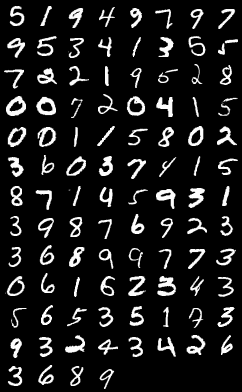

In [24]:
from IPython.display import Image
from torchvision.utils import save_image


# Saev the model real images
for images , _ in data_loader:
  images = images.reshape(images.size(0) , 1 , 28 , 28)
  save_image(denorm(images) , os.path.join(sample_dir , 'real_images.png'))
  break

Image(os.path.join(sample_dir , 'real_images.png'))


Saving fake_images-0000.png


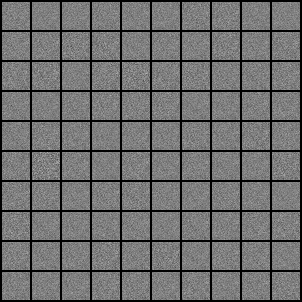

In [25]:
sample_vector = torch.randn(batch_size , latent_size).to(device)

def save_fake_images(index): # INdex will be the epochs number
  fake_images = G(sample_vector)
  fake_images = fake_images.reshape(fake_images.size(0) , 1 , 28 , 28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving' , fake_fname)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)




# Before training
save_fake_images(0)
Image(os.path.join(sample_dir , 'fake_images-0000.png'))


#### We are now ready to train the modeltrain the discriminator first and the generator

In [26]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)


Epoch [0/300], Step [200/600], d_loss: 0.8379, g_loss: 0.7108, D(x): 0.96, D(G(z)): 0.55
Epoch [0/300], Step [400/600], d_loss: 0.8020, g_loss: 0.7078, D(x): 0.97, D(G(z)): 0.54
Epoch [0/300], Step [600/600], d_loss: 0.8939, g_loss: 0.7153, D(x): 0.95, D(G(z)): 0.57
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 1.0709, g_loss: 0.6403, D(x): 0.88, D(G(z)): 0.61
Epoch [1/300], Step [400/600], d_loss: 0.8691, g_loss: 0.6662, D(x): 0.95, D(G(z)): 0.55
Epoch [1/300], Step [600/600], d_loss: 0.9255, g_loss: 0.6685, D(x): 0.91, D(G(z)): 0.56
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 1.1612, g_loss: 0.5542, D(x): 0.85, D(G(z)): 0.63
Epoch [2/300], Step [400/600], d_loss: 1.5378, g_loss: 0.4167, D(x): 0.73, D(G(z)): 0.70
Epoch [2/300], Step [600/600], d_loss: 0.9022, g_loss: 0.6025, D(x): 0.90, D(G(z)): 0.55
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.0404, g_loss: 0.5701, D(x): 0.85, D(G(z)): 0.58
Epoch [3/300], Step [400/6

In [27]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

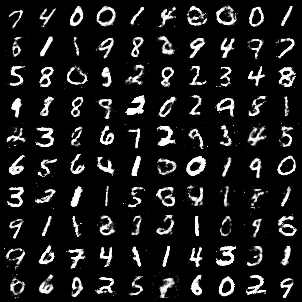

In [37]:
Image('./samples/fake_images-0300.png')

In [29]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')


/content/gans_training.avi

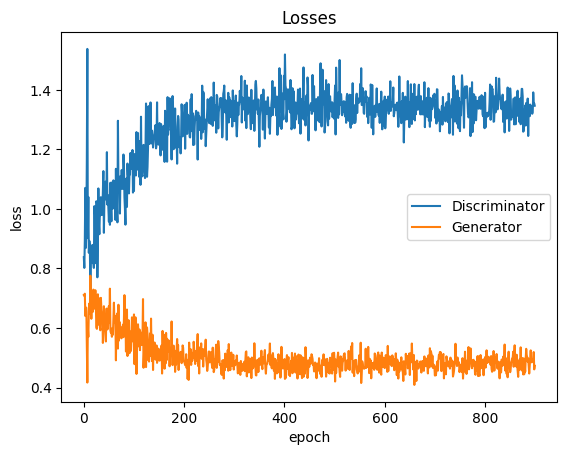

In [30]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

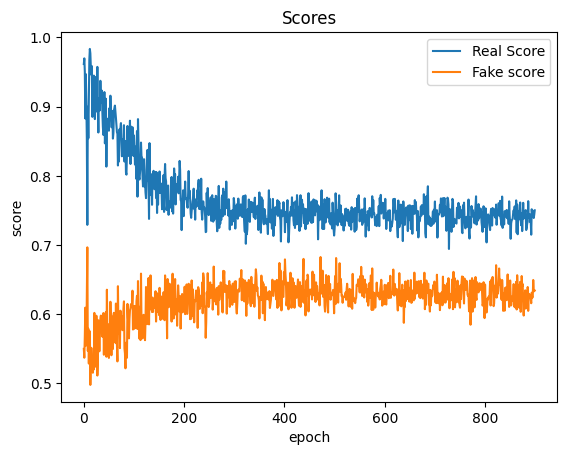

In [31]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [32]:
# Install the library
!pip install jovian --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [33]:
# Import the library
import jovian

In [34]:
jovian.commit(outputs=['samples/fake_images-0000.png',
                       'samples/fake_images-0010.png',
                       'samples/fake_images-0025.png',
                       'samples/fake_images-0050.png',
                       'samples/fake_images-0100.png',
                       'samples/fake_images-0150.png',
                       'samples/fake_images-0200.png',
                       'samples/fake_images-0250.png',
                       'samples/fake_images-0300.png',
                       'gans_training.avi'],
              project='06-mnist-gan')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [35]:
### Adam  : RMSProp + Momentum

# moment1 = 0
# moment2 = 0
# beta1 = 1
# beta2 = 1
# learning_rate = 1e-3

# for t in range(num_steps):
#   dw = compute_gradient(w)
#   moment1 = beta1 * moment1 + (1 - beta1) * dw
#   moment2 = beta2 * moment2 + (1 - beta2) * dw * dw
#   moment1_unbias =  moment1 / (1 - beta1 ** t)
#   moment2_unbias = moment2 / (1 - beta2 ** t)
#   w -= learning_rate * moment1_unbias / (moment2_unbias.sgrt() + 1e-7)

